In [7]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# Load your dataset
data = pd.read_csv('Unemployment Data.csv')

# Check the first five records
first_five_records = data.head()

print('First Five Records\n', first_five_records)

First Five Records
    REF_DATE     GEO           DGUID Labour force characteristics  \
0      1997  Canada  2016A000011124                 Labour force   
1      1998  Canada  2016A000011124                 Labour force   
2      1999  Canada  2016A000011124                 Labour force   
3      2000  Canada  2016A000011124                 Labour force   
4      2001  Canada  2016A000011124                 Labour force   

  North American Industry Classification System (NAICS)         Sex  \
0                              Total, all industries     Both sexes   
1                              Total, all industries     Both sexes   
2                              Total, all industries     Both sexes   
3                              Total, all industries     Both sexes   
4                              Total, all industries     Both sexes   

        Age group      UOM  UOM_ID SCALAR_FACTOR  SCALAR_ID     VECTOR  \
0  15 to 24 years  Persons     249     thousands          3  v19668072

In [ ]:
# Drop unnecessary columns
columns_to_drop = ['DGUID', 'UOM_ID', 'SCALAR_ID', 'COORDINATE', 'VECTOR', 'STATUS', 'SYMBOL', 'TERMINATED', 'DECIMALS']
data_emp = data.drop(columns=columns_to_drop)

# Separating the 'North American Industry Classification System (NAICS)' into two columns
data_emp[['industry_classification', 'NAICS']] = data_emp['North American Industry Classification System (NAICS)'].str.extract(r'([^\[]+)\s*\[([^\]]+)\]')
data_emp = data_emp.drop(columns=['North American Industry Classification System (NAICS)'])

# Ensure new columns are properly formatted
data_emp['industry_classification'] = data_emp['industry_classification'].str.strip().astype('category')
data_emp['NAICS'] = data_emp['NAICS'].str.strip()

# Standardizing Data Formats
categorical_columns = ['GEO', 'Labour force characteristics', 'Sex', 'Age group', 'industry_classification']
for column in categorical_columns:
    data_emp[column] = data_emp[column].astype(str).str.lower()

# Convert 'REF_DATE' to datetime format
data_emp['REF_DATE'] = pd.to_datetime(data_emp['REF_DATE'], format='%Y')

# Ensure all categorical variables are type 'category'
for column in categorical_columns:
    data_emp[column] = data_emp[column].astype('category')

# Ensure 'VALUE' is numeric
data_emp['VALUE'] = pd.to_numeric(data_emp['VALUE'], errors='coerce')

C:\Users\nesha\AppData\Local\Temp\ipykernel_30908\3852008194.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_emp, y='VALUE', palette='viridis')


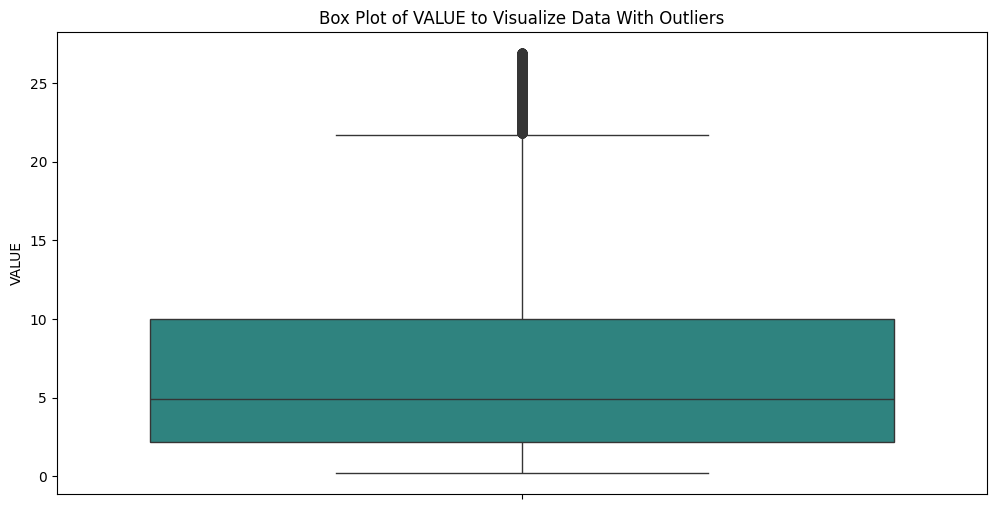

C:\Users\nesha\AppData\Local\Temp\ipykernel_30908\3852008194.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=data_emp_clean, y='VALUE', palette='viridis')


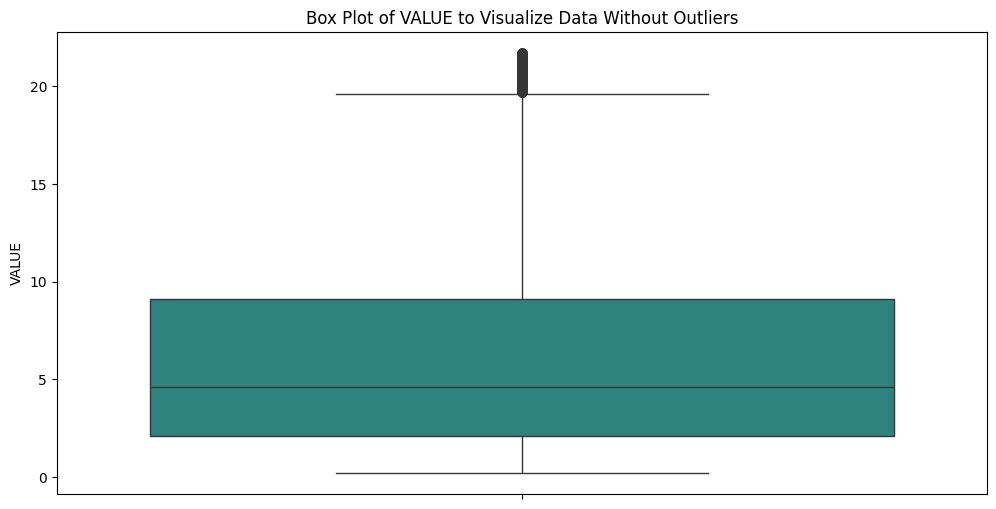

Data Shape Before Removing Outliers: (55263, 10)
Data Shape After Removing Outliers: (53040, 10)


In [16]:
# Create a separate DataFrame for rows with missing data for later assessment
data_missing = data_emp[data_emp.isnull().any(axis=1)]

# Remove rows with any missing/NA/NAN/NULL data from the working dataset
data_emp = data_emp.dropna()


# Visualize the outliers using a box plot before filtering
before_outliers = plt.figure(figsize=(12, 6))
sns.boxplot(data=data_emp, y='VALUE', palette='viridis')
plt.title('Box Plot of VALUE to Visualize Data With Outliers')
plt.show()

# Identifying and Correcting Anomalies/Outliers
# For continuous data, using the IQR method to detect and remove outliers
Q1 = data_emp['VALUE'].quantile(0.25)
Q3 = data_emp['VALUE'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtering out the outliers
data_emp_clean = data_emp[(data_emp['VALUE'] >= lower_bound) & (data_emp['VALUE'] <= upper_bound)]

# Visualize the outliers using a box plot before filtering
after_outliers = plt.figure(figsize=(12, 6))
sns.boxplot(data=data_emp_clean, y='VALUE', palette='viridis')
plt.title('Box Plot of VALUE to Visualize Data Without Outliers')
plt.show()

# Print the shape of the dataset after removing outliers
print('Data Shape Before Removing Outliers:', data_emp.shape)
print('Data Shape After Removing Outliers:', data_emp_clean.shape)

In [18]:
print(data_emp_clean.head())

      REF_DATE     GEO Labour force characteristics      Sex       Age group  \
405 1997-01-01  canada                 labour force  females  15 to 24 years   
407 1999-01-01  canada                 labour force  females  15 to 24 years   
408 2000-01-01  canada                 labour force  females  15 to 24 years   
409 2001-01-01  canada                 labour force  females  15 to 24 years   
410 2002-01-01  canada                 labour force  females  15 to 24 years   

         UOM SCALAR_FACTOR  VALUE industry_classification  \
405  Persons     thousands   19.9             agriculture   
407  Persons     thousands   20.4             agriculture   
408  Persons     thousands   17.9             agriculture   
409  Persons     thousands   16.4             agriculture   
410  Persons     thousands   17.3             agriculture   

                        NAICS  
405  111-112, 1100, 1151-1152  
407  111-112, 1100, 1151-1152  
408  111-112, 1100, 1151-1152  
409  111-112, 1100, 1151

In [20]:
# Calculate descriptive statistics for employment ('VALUE') by 'NAICS' and 'REF_DATE'
emp_by_naics_ref_date = data_emp_clean.groupby(['NAICS', 'REF_DATE'], observed=True)['VALUE'].describe()
print('Descriptive Statistics for Employment by NAICS and REF_DATE:')
print(emp_by_naics_ref_date.head())

# Calculate descriptive statistics for employment ('VALUE') by 'NAICS'  and 'Age group'
wages_by_naics_age_group = data_emp_clean.groupby(['NAICS', 'Age group'], observed=True)['VALUE'].describe()
print('\nDescriptive Statistics for Employment by NAICS and Age Group:')
print(wages_by_naics_age_group.head())

# Calculate descriptive statistics for employment ('VALUE') by 'NAICS' and 'Sex'
wages_by_naics_sex = data_emp_clean.groupby(['NAICS', 'Sex'], observed=True)['VALUE'].describe()
print('\nDescriptive Statistics for Employment by NAICS and Sex:')
print(wages_by_naics_sex.head())

# Calculate descriptive statistics for employment ('VALUE') by 'NAICS' and 'GEO'
wages_by_naics_geo = data_emp_clean.groupby(['NAICS', 'GEO'], observed=True)['VALUE'].describe()
print('\nDescriptive Statistics for Employment by NAICS and Geographic Location:')
print(wages_by_naics_geo.head())

Descriptive Statistics for Wages by NAICS and REF_DATE:
                                     count      mean       std  min    25%  \
NAICS                    REF_DATE                                            
111-112, 1100, 1151-1152 1997-01-01   91.0  7.653846  6.216989  0.2  1.950   
                         1998-01-01   92.0  7.207609  5.752080  0.2  1.975   
                         1999-01-01   88.0  7.052273  6.041351  0.2  1.900   
                         2000-01-01   84.0  6.938095  5.598578  0.2  1.850   
                         2001-01-01   92.0  7.083696  5.890881  0.2  1.975   

                                      50%     75%   max  
NAICS                    REF_DATE                        
111-112, 1100, 1151-1152 1997-01-01  6.10  13.500  21.1  
                         1998-01-01  5.95  11.200  20.0  
                         1999-01-01  5.15  11.225  20.8  
                         2000-01-01  5.45  10.550  21.4  
                         2001-01-01  4.85  12.300

In [21]:
# Calculate descriptive statistics for employment ('VALUE') by 'REF_DATE' and 'Age group' for January of each year
data_emp_clean['REF_DATE'] = pd.to_datetime(data_emp_clean['REF_DATE'])
data_january = data_emp_clean[data_emp_clean['REF_DATE'].dt.month == 1]

# Descriptive statistics for wages ('VALUE') by 'Age group' for January of each year
wages_by_age_group_january = data_january.groupby(['REF_DATE', 'Age group'], observed=True)['VALUE'].describe()
print('\nDescriptive Statistics for Wages by Age Group for January of Each Year:')
print(wages_by_age_group_january.head())

# Descriptive statistics for wages ('VALUE') by 'Sex' for January of each year
wages_by_sex_january = data_january.groupby(['REF_DATE', 'Sex'], observed=True)['VALUE'].describe()
print('\nDescriptive Statistics for Wages by Sex for January of Each Year:')
print(wages_by_sex_january.head())

# Descriptive statistics for wages ('VALUE') by 'GEO' for January of each year
wages_by_geo_january = data_january.groupby(['REF_DATE', 'GEO'], observed=True)['VALUE'].describe()
print('\nDescriptive Statistics for Wages by Geographic Location for January of Each Year:')
print(wages_by_geo_january.head())

# Descriptive statistics for wages ('VALUE') by 'industry_classification' for January of each year
wages_by_industry_classification_january = data_january.groupby(['REF_DATE', 'industry_classification'], observed=True)['VALUE'].describe()
print('\nDescriptive Statistics for Wages by Industry Classification for January of Each Year:')
print(wages_by_industry_classification_january.head())

# Descriptive statistics for wages ('VALUE') by 'NAICS' for January of each year
wages_by_naics_january = data_january.groupby(['REF_DATE', 'NAICS'], observed=True)['VALUE'].describe()
print('\nDescriptive Statistics for Wages by NAICS for January of Each Year:')
print(wages_by_naics_january.head())


C:\Users\nesha\AppData\Local\Temp\ipykernel_30908\3147020240.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_emp_clean['REF_DATE'] = pd.to_datetime(data_emp_clean['REF_DATE'])



Descriptive Statistics for Wages by Age Group for January of Each Year:
                              count      mean       std  min    25%  50%  \
REF_DATE   Age group                                                       
1997-01-01 15 to 24 years     668.0  6.922904  5.698133  0.2  1.875  5.6   
           25 to 54 years     802.0  7.313342  5.334504  0.2  3.400  5.4   
           55 years and over  501.0  4.779441  5.000524  0.2  1.100  2.8   
1998-01-01 15 to 24 years     669.0  6.848132  5.668733  0.2  1.800  5.6   
           25 to 54 years     799.0  7.083605  5.125964  0.2  3.300  5.5   

                               75%   max  
REF_DATE   Age group                      
1997-01-01 15 to 24 years     10.9  21.6  
           25 to 54 years     10.2  21.7  
           55 years and over   6.8  21.2  
1998-01-01 15 to 24 years     11.0  21.7  
           25 to 54 years      9.6  21.6  

Descriptive Statistics for Wages by Sex for January of Each Year:
                       cou